## 1(A)

In [1]:
import numpy as np
import pandas as pd
import cvxopt
from cvxopt import solvers,matrix
from sklearn.svm import SVC
import math
from tqdm import tqdm
import multiprocessing as mp
from multiprocessing import Pool
import itertools
import threading
import pickle
from joblib import Parallel, delayed
import time
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [2]:
def init():
    train = pd.read_csv("fashion_mnist/train.csv",header=None)
    val = pd.read_csv("fashion_mnist/val.csv",header=None)
    test = pd.read_csv("fashion_mnist/test.csv",header=None)
    return train,val,test

In [4]:
train,val,test = init()
c1=3
c2=4

In [5]:
def stripData(data,c1,c2):
    data = data[data[784]==c1].append(data[data[784]==c2])
    data.loc[data[784]==c1,784]=-1
    data.loc[data[784]==c2,784]=1
    Y = np.reshape(np.array(data[784]),(-1,1))
    pos = data[data[784]==1]
    neg = data[data[784]==-1]
    data = np.array(data.drop(columns=[784]))/255
    return data,Y,pos,neg

In [6]:
train = train[train[784]==c1].append(train[train[784]==c2])

In [7]:
train.loc[train[784]==c1,784]=-1
train.loc[train[784]==c2,784]=1
pos = train[train[784]==1]
neg = train[train[784]==-1]
Y = np.array(train[784])
trainD = np.array(train.drop(columns=[784]))/255

In [8]:
Y = Y.reshape((Y.shape[0],1))

In [9]:
trainD.shape

(4500, 784)

In [10]:
def createPq(data,out):
    P = (out@out.T)*(data@data.T)
    q = (-1)*np.ones((P.shape[0],1))
    return matrix(P),matrix(q)

def createGh(m):
    u = np.identity(m)
    d = (-1)*np.identity(m)
    G = np.append(u,d,axis=0)
    h = np.append(np.ones((m,1)),np.zeros((m,1)),axis=0)
    return matrix(G),matrix(h)

def createAb(out):
    m = out.shape[0]
    A = out.copy()
    A = A.T
    b = 0
    return matrix(A,(1,m),'d'),matrix(b,(1,1),'d')

In [11]:
P,q = createPq(trainD,Y)
G,h = createGh(trainD.shape[0])
A,B = createAb(Y)

In [12]:
sol=solvers.qp(P, q, G, h, A, B)

     pcost       dcost       gap    pres   dres
 0: -7.6996e+02 -9.4221e+03  5e+04  3e+00  2e-11
 1: -5.0971e+02 -5.5267e+03  1e+04  4e-01  2e-11
 2: -3.4948e+02 -1.8871e+03  3e+03  1e-01  2e-11
 3: -2.7529e+02 -9.4339e+02  1e+03  4e-02  1e-11
 4: -2.3683e+02 -5.8695e+02  6e+02  2e-02  1e-11
 5: -2.1335e+02 -3.9050e+02  3e+02  6e-03  1e-11
 6: -2.1473e+02 -2.5858e+02  6e+01  9e-04  1e-11
 7: -2.1941e+02 -2.3321e+02  2e+01  2e-04  1e-11
 8: -2.2236e+02 -2.2552e+02  3e+00  2e-05  1e-11
 9: -2.2339e+02 -2.2362e+02  2e-01  6e-07  1e-11
10: -2.2348e+02 -2.2349e+02  1e-02  3e-08  1e-11
11: -2.2348e+02 -2.2348e+02  2e-04  5e-10  1e-11
Optimal solution found.


In [13]:
alpha = np.array(sol['x'])

In [14]:
alpha.max()

0.9999999952478656

In [15]:
def stripAlpha(alpha,E):
    index = alpha < E
    alpha[index] = 0
    return alpha

In [16]:
alpha = stripAlpha(alpha,1e-4)

In [21]:
index = alpha != 0
index.sum()

494

In [22]:
def calwb(alpha,X,Y,pos,neg):
    w = X.T@(alpha*Y)
    x = (np.array(pos.drop(columns=[784]))/255)
    y = (np.array(neg.drop(columns=[784]))/255)
    b = (-1)*((x@w).min()+(y@w).max())/2
    return w,b

In [23]:
w,b = calwb(alpha,trainD,Y,pos,neg)

In [25]:
def predClasses(w,b,data):
    pred = []
    for i in data:
        temp = i.reshape((1,-1))@w+b
        if temp<0:
            pred.append(-1)
        else:
            pred.append(1)
    return pred

In [26]:
predictionTrain = predClasses(w,b,trainD)

In [27]:
def checkAccuracy(y,pred):
    y = np.array(y).reshape((-1,1))
    pred = np.array(pred).reshape((-1,1))
    check = (y==pred)
    t=0
    f=0
    for i in check:
        if i:
            t=t+1
        else:
            f=f+1
    print(t/(t+f))

In [28]:
checkAccuracy(train[784],predictionTrain)

0.9862222222222222


In [29]:
testX,testY,_,_ = stripData(test,c1,c2)
valX,valY,_,_ = stripData(val,c1,c2)

In [30]:
predictionTest = predClasses(w,b,testX)
checkAccuracy(testY,np.array(predictionTest))

0.945


In [31]:
testX.shape

(1000, 784)

In [32]:
predictionVal = predClasses(w,b,valX)
checkAccuracy(valY,predictionVal)

0.936


## 1(B)

In [35]:
def K(x,z,gamma=0.05):
    norm = np.reshape((x-z),(1,-1))
    norm = norm@norm.T
    return math.exp((-gamma)*norm)

In [36]:
def gaussianPq(data,out):
    m = data.shape[0]
    kernelMatrix=np.exp((-0.05)*np.square(distance.cdist(data,data,'euclidean')))
    P = (out@out.T)*kernelMatrix
    q = (-1)*np.ones((P.shape[0],1))
    return matrix(P),matrix(q)

In [37]:
P,q = gaussianPq(trainD,Y)
G,h = createGh(trainD.shape[0])
A,B = createAb(Y)

In [38]:
sol=solvers.qp(P, q, G, h, A, B)

     pcost       dcost       gap    pres   dres
 0: -4.2846e+02 -7.6683e+03  3e+04  2e+00  7e-15
 1: -3.2882e+02 -4.1247e+03  6e+03  2e-01  7e-15
 2: -3.0989e+02 -9.4797e+02  7e+02  2e-02  7e-15
 3: -3.7592e+02 -5.6057e+02  2e+02  4e-03  6e-15
 4: -4.0510e+02 -4.5864e+02  6e+01  7e-04  6e-15
 5: -4.1586e+02 -4.3199e+02  2e+01  1e-04  7e-15
 6: -4.1976e+02 -4.2383e+02  4e+00  1e-05  7e-15
 7: -4.2092e+02 -4.2164e+02  7e-01  6e-14  7e-15
 8: -4.2117e+02 -4.2123e+02  6e-02  2e-13  7e-15
 9: -4.2119e+02 -4.2119e+02  1e-03  5e-13  7e-15
10: -4.2119e+02 -4.2119e+02  2e-05  5e-13  7e-15
Optimal solution found.


In [39]:
alpha = np.array(sol['x'])

In [40]:
# 1e-2 = 98.997 96.3 96.2
# 1e-3 = 99.1 96.1 96
alpha = stripAlpha(alpha,1e-4)

In [41]:
index = alpha != 0
index.sum()

1265

In [42]:
def calb(alpha,X,Y,pos,neg):
    x = (np.array(pos.drop(columns=[784]))/255)
    y = (np.array(neg.drop(columns=[784]))/255)
    Y.reshape((-1,1))
    p = ((alpha*Y)*(np.exp((-0.05)*np.square(distance.cdist(X,x,'euclidean'))))).sum(axis=0).min()
    n = ((alpha*Y)*(np.exp((-0.05)*np.square(distance.cdist(X,y,'euclidean'))))).sum(axis=0).max()
    b = (-1)*(p+n)/2
    return b

In [43]:
b = calb(alpha,trainD,Y,pos,neg)

In [44]:
b

-0.14470232827838264

In [45]:
def predGaussianClasses(alpha,b,X,Y,data,return_score=False):
    pred=[]
    pred = ((alpha*Y)*(np.exp((-0.05)*np.square(distance.cdist(X,data,'euclidean'))))).sum(axis=0)
    pred = pred+b
    if(return_score):
        return pred
    index = pred < 0
    pred[index]=-1
    index = pred >= 0
    pred[index]=1
    return pred

In [46]:
predictionTrain = predGaussianClasses(alpha,b,trainD,Y,trainD)
predictionTest = predGaussianClasses(alpha,b,trainD,Y,testX)
predictionVal = predGaussianClasses(alpha,b,trainD,Y,valX)

In [47]:
checkAccuracy(Y,predictionTrain)
checkAccuracy(testY,predictionTest)
checkAccuracy(valY,predictionVal)

0.99
0.961
0.96


## 1(C)

In [48]:
clfLinear = SVC(C=1.0,kernel='linear')
clfGaussian = SVC(C=1.0,kernel='rbf',gamma=0.05)

In [49]:
clfLinear.fit(trainD, train[784])
clfGaussian.fit(trainD, train[784])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [53]:
print(clfLinear.support_vectors_.shape)
print(clfGaussian.support_vectors_.shape)

(493, 784)
(1259, 784)


In [54]:
testX,testY,_,_ = stripData(test,c1,c2)
valX,valY,_,_ = stripData(val,c1,c2)

In [55]:
predictionTrain = clfLinear.predict(trainD)
predictionTest = clfLinear.predict(testX)
predictionVal = clfLinear.predict(valX)

In [56]:
checkAccuracy(train[784],predictionTrain)
checkAccuracy(valY,predictionVal)
checkAccuracy(testY,predictionTest)

0.9862222222222222
0.934
0.943


In [57]:
predictionTrain = clfGaussian.predict(trainD)
predictionTest = clfGaussian.predict(testX)
predictionVal = clfGaussian.predict(valX)

In [58]:
checkAccuracy(train[784],predictionTrain)
checkAccuracy(valY,predictionVal)
checkAccuracy(testY,predictionTest)

0.9902222222222222
0.964
0.965


## 2(A)

In [59]:
globalTrain,globalVal,globalTest = init()

In [60]:
def createClf(data,classes):
    c1 = classes[0]
    c2 = classes[1]
    filteredX,filteredY,pos,neg = stripData(data,c1,c2)

    P,q = gaussianPq(filteredX,filteredY)
    G,h = createGh(filteredX.shape[0])
    A,b = createAb(filteredY)
    sol=solvers.qp(P, q, G, h, A, B)
    alpha = np.array(sol['x'])
    alpha = stripAlpha(alpha,1e-4)
    print("Alpha Done.")
    b = calb(alpha,filteredX,filteredY,pos,neg)
    print("b Done.")
    return (alpha,b,c1,c2)

In [61]:
l = list(itertools.combinations([0,1,2,3,4,5,6,7,8,9], 2))

In [62]:
pickle_in = open("oneVone.pickle","rb")
paraList = pickle.load(pickle_in)

In [63]:
# st = time.time()
# temp = Parallel(n_jobs=-2)(delayed(createClf)(globalTrain,i) for i in l)
# print(time.time()-st)

In [64]:
# with open('oneVone.pickle', 'wb') as f:
#     pickle.dump(temp, f)

In [65]:
def classify(paraList,X,data):
    pred=[]
    for i in tqdm(paraList):
        filteredX,filteredY,pos,neg = stripData(X,i[2],i[3])
        pred.append(predGaussianClasses(i[0],i[1],filteredX,filteredY,data,return_score=True))
    return pred

In [66]:
# globalTrain = np.array(globalTrain.drop(columns=[784]))/255
# globalVal = np.array(globalVal.drop(columns=[784]))/255
# globalTest = np.array(globalTest.drop(columns=[784]))/255

In [67]:
testY = globalTest[784]
testX = np.array(globalTest.drop(columns=[784]))/255

In [68]:
testY.shape

(5000,)

In [69]:
predictions = classify(paraList,globalTrain,testX)

100%|██████████| 45/45 [07:16<00:00,  9.69s/it]


In [70]:
len(predictions)

45

In [71]:
def findMajorityClass(predictions,l,calculations='cal'):
    pred = []
    n = len(predictions)
    m = len(predictions[0])
    for i in tqdm(range(m)):
        temp = np.zeros((10,2))
        for j in range(n):
            if(calculations=="cal"):
                if(predictions[j][i]<0):
                    temp[l[j][0],0]+=1
                    temp[l[j][0],1]+=abs(predictions[j][i])
                else:
                    temp[l[j][1],0]+=1
                    temp[l[j][1],1]+=abs(predictions[j][i])
            elif(calculations=="SVC"):
                if(predictions[j][i][0]>predictions[j][i][1]):
                    temp[l[j][0],0]+=1
                    temp[l[j][0],1]+=abs(predictions[j][i][0])
                else:
                    temp[l[j][1],0]+=1
                    temp[l[j][1],1]+=abs(predictions[j][i][1])
        m=max(temp[:,0])
        index=0
        score=-1
        for i in range(10):
            if(temp[i][0]==m and temp[i][1]>score):
                index=i
                score=temp[i][1]
        pred.append(index)
    return pred

In [72]:
oneVonePred = findMajorityClass(predictions,l)

100%|██████████| 5000/5000 [00:00<00:00, 13037.86it/s]


In [73]:
checkAccuracy(testY,oneVonePred)

0.8508


In [74]:
valY = globalVal[784]
valX = np.array(globalVal.drop(columns=[784]))/255

In [75]:
valX.shape

(2500, 784)

In [76]:
predictionsVal = classify(paraList,globalTrain,valX)

100%|██████████| 45/45 [03:24<00:00,  4.54s/it]


In [77]:
oneVonePredVal = findMajorityClass(predictionsVal,l)
checkAccuracy(valY,oneVonePredVal)

100%|██████████| 2500/2500 [00:00<00:00, 14390.94it/s]

0.8496


In [78]:
trainY = globalTrain[784]
trainX = np.array(globalTrain.drop(columns=[784]))/255

In [79]:
# predictionsTrain = classify(paraList,globalTrain,trainX)

In [80]:
# oneVonePredTrain = findMajorityClass(predictionsTrain,l)
# checkAccuracy(trainY,oneVonePredTrain)

## 2(B)

In [81]:
def createSVMs(data,classes):
    c1 = classes[0]
    c2 = classes[1]
    filteredX,filteredY,pos,neg = stripData(data,c1,c2)
    filteredY.reshape((1,-1))
    clf = SVC(C=1.0,kernel='rbf',gamma=0.05,probability=True)
    clf.fit(filteredX,filteredY.ravel())
    print("Done")
    return clf

def allPredictions(clfList,data):
    pred = []
    for i in tqdm(clfList):
        x = i.predict_proba(data)
        pred.append(x)
    return pred

In [82]:
# st = time.time()
# temp = Parallel(n_jobs=-2)(delayed(createSVMs)(globalTrain,i) for i in l)
# print(time.time()-st)

In [83]:
# with open('oneVoneSVM.pickle', 'wb') as f:
#     pickle.dump(temp, f)

In [84]:
pickle_in = open("oneVoneSVM.pickle","rb")
clfList = pickle.load(pickle_in)

In [85]:
testY = globalTest[784]
testX = np.array(globalTest.drop(columns=[784]))/255

In [86]:
predictionsTest = allPredictions(clfList,testX)

100%|██████████| 45/45 [02:55<00:00,  3.90s/it]


In [87]:
oneVonePredSVC = findMajorityClass(predictionsTest,l,calculations="SVC")

100%|██████████| 5000/5000 [00:00<00:00, 10155.91it/s]


In [88]:
checkAccuracy(testY,oneVonePredSVC)

0.8814


In [89]:
valY = globalVal[784]
valX = np.array(globalVal.drop(columns=[784]))/255

In [90]:
predictionsVal = allPredictions(clfList,valX)

100%|██████████| 45/45 [01:27<00:00,  1.95s/it]


In [91]:
oneVonePredVal = findMajorityClass(predictionsVal,l,calculations="SVC")
checkAccuracy(valY,oneVonePredVal)

100%|██████████| 2500/2500 [00:00<00:00, 10986.12it/s]

0.8808


# 2(C)

In [92]:
def confusionMatrix(test,prediction):
    mat = np.zeros((10,10))
    index=0
    for i in range(len(prediction)):
        mat[int(test[i]),int(prediction[i])] += 1
    return mat

In [93]:
valY[12]

3.0

In [94]:
confusion = confusionMatrix(valY,oneVonePredVal)
confusion

array([[211.,   1.,   1.,   8.,   0.,   0.,  27.,   0.,   2.,   0.],
       [  0., 239.,   2.,   6.,   0.,   0.,   2.,   0.,   1.,   0.],
       [  5.,   0., 206.,   3.,  19.,   0.,  13.,   0.,   4.,   0.],
       [  5.,   0.,   0., 229.,   6.,   0.,   9.,   0.,   1.,   0.],
       [  1.,   1.,  23.,   8., 201.,   0.,  15.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.,   0., 240.,   0.,   2.,   1.,   6.],
       [ 32.,   0.,  27.,   4.,  20.,   0., 166.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   8.,   0., 230.,   1.,  11.],
       [  0.,   0.,   1.,   1.,   1.,   0.,   1.,   2., 244.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   5.,   0.,   8.,   1., 236.]])

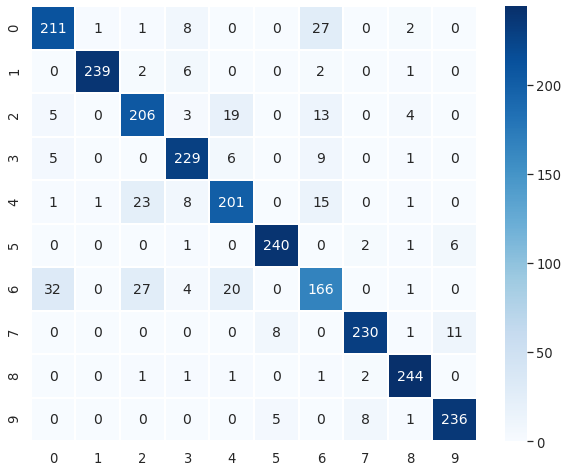

In [95]:
df_cm = pd.DataFrame(confusion.astype(int), index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,8))
sns.set(font_scale=1.2)
sns.heatmap(df_cm,cmap="Blues", annot=True,fmt="d",linewidth=1,annot_kws={"size": 14})

# 2(D)

In [96]:
trainY = globalTrain[784]
trainX = np.array(globalTrain.drop(columns=[784]))/255

testY = globalTest[784]
testX = np.array(globalTest.drop(columns=[784]))/255

In [124]:
def findAccuracyParallel(data,c):
    clf = SVC(C=c,kernel='rbf',gamma=0.05)
    clf.fit(data[0],data[1])
    print("Done")
    
    v = clf.score(data[2],data[3])
    t = clf.score(data[4],data[5])
    return (v,t,c)
    

def verifyKfold(trainX,trainY,testX,testY):
    kf = KFold(n_splits=5)
    kf.get_n_splits(trainX)
    C = [1e-5,1e-3,1,5,10]
    
    accuracies=[]
    for trainId,testId in kf.split(trainX):
        X_train, X_val = trainX[trainId], trainX[testId]
        Y_train, Y_val = trainY[trainId], trainY[testId]
        pass
        st = time.time()
        data = [X_train,Y_train,X_val,Y_val,testX,testY]
        
        t = time.time()
        clf = SVC(C=1e-5,kernel='rbf',gamma=0.05)
        clf.fit(X_train,Y_train)
        print(clf.score(testX,testY),time.time()-t)
        clf = SVC(C=1e-3,kernel='rbf',gamma=0.05)
        clf.fit(X_train,Y_train)
        print(clf.score(testX,testY))
        clf = SVC(C=1,kernel='rbf',gamma=0.05)
        clf.fit(X_train,Y_train)
        print(clf.score(testX,testY))
        clf = SVC(C=5,kernel='rbf',gamma=0.05)
        clf.fit(X_train,Y_train)
        print(clf.score(testX,testY))
        clf = SVC(C=10,kernel='rbf',gamma=0.05)
        clf.fit(X_train,Y_train)
        print(clf.score(testX,testY))
#         temp = Parallel(n_jobs=-2)(delayed(findAccuracyParallel)(data,i) for i in C)
        print(time.time()-st)
        print(temp)
        accuracies.append(temp)
        break
    return accuracies

In [ ]:
Kfold = verifyKfold(trainX,trainY,testX,testY)

In [111]:
# with open('kFold.pickle', 'wb') as f:
#     pickle.dump(Kfold, f)

In [101]:
pickle_in = open("kFold.pickle","rb")
accList = pickle.load(pickle_in)

In [103]:
accList

[[(0.09466666666666666, 0.1, 1e-05),
  (0.09466666666666666, 0.1, 0.001),
  (0.8771111111111111, 0.8768, 1),
  (0.88, 0.8782, 5),
  (0.8784444444444445, 0.8772, 10)],
 [(0.09688888888888889, 0.1, 1e-05),
  (0.09688888888888889, 0.1, 0.001),
  (0.8755555555555555, 0.8742, 1),
  (0.8808888888888889, 0.8772, 5),
  (0.8815555555555555, 0.8762, 10)],
 [(0.09444444444444444, 0.1, 1e-05),
  (0.09444444444444444, 0.1, 0.001),
  (0.8817777777777778, 0.8754, 1),
  (0.888, 0.88, 5),
  (0.8884444444444445, 0.8806, 10)],
 [(0.09333333333333334, 0.1, 1e-05),
  (0.09333333333333334, 0.1, 0.001),
  (0.8744444444444445, 0.8728, 1),
  (0.8833333333333333, 0.8792, 5),
  (0.8828888888888888, 0.8782, 10)],
 [(0.094, 0.1, 1e-05),
  (0.094, 0.1, 0.001),
  (0.8837777777777778, 0.8728, 1),
  (0.884, 0.8794, 5),
  (0.8848888888888888, 0.8778, 10)]]

In [106]:
clf = SVC(C=1e-5,kernel='rbf',gamma=0.05)
clf.fit(trainX,trainY)

SVC(C=1e-05, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [107]:
v = clf.score(testX,testY)

In [108]:
v

0.5736

In [ ]:
def valList()